In [3]:
import string
import re
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

ModuleNotFoundError: No module named 'keras'

In [2]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("hin.txt")
data = to_lines(data)
data=np.array(data)

In [5]:
data=data.tolist()

In [6]:
df=[data[i][:2] for i in range(len(data))]

In [7]:
df=np.array(df)

In [8]:
df[:10]

array([['Wow!', 'वाह!'],
       ['Help!', 'बचाओ!'],
       ['Jump.', 'उछलो.'],
       ['Jump.', 'कूदो.'],
       ['Jump.', 'छलांग.'],
       ['Hello!', 'नमस्ते।'],
       ['Hello!', 'नमस्कार।'],
       ['Cheers!', 'वाह-वाह!'],
       ['Cheers!', 'चियर्स!'],
       ['Got it?', 'समझे कि नहीं?']], dtype='<U121')

In [9]:
df.shape

(2774, 2)

In [10]:
df[:,0]

array(['Wow!', 'Help!', 'Jump.', ...,
       'Democracy is the worst form of government, except all the others that have been tried.',
       'If my boy had not been killed in the traffic accident, he would be a college student now.',
       "When I was a kid, touching bugs didn't bother me a bit. Now I can hardly stand looking at pictures of them."],
      dtype='<U121')

In [11]:
df[:,1]

array(['वाह!', 'बचाओ!', 'उछलो.', ...,
       'लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी सारी तरह की सरकारों को अंदेखा किया जाए तो।',
       'अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया होता, तो वह अभी कॉलेज जा रहा होता।',
       'जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई परेशानी नहीं होती थी, पर अब मैं उनकी तस्वीरें देखना भी बर्दाश्त नहीं कर सकता।'],
      dtype='<U121')

In [12]:
df[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in df[:,0]]
df[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in df[:,1]]

In [13]:
df[:10]

array([['Wow', 'वाह'],
       ['Help', 'बचाओ'],
       ['Jump', 'उछलो'],
       ['Jump', 'कूदो'],
       ['Jump', 'छलांग'],
       ['Hello', 'नमस्ते।'],
       ['Hello', 'नमस्कार।'],
       ['Cheers', 'वाहवाह'],
       ['Cheers', 'चियर्स'],
       ['Got it', 'समझे कि नहीं']], dtype='<U121')

In [14]:
for i in range(len(df)):
    df[i,0] = df[i,0].lower()

In [15]:
df[:10]

array([['wow', 'वाह'],
       ['help', 'बचाओ'],
       ['jump', 'उछलो'],
       ['jump', 'कूदो'],
       ['jump', 'छलांग'],
       ['hello', 'नमस्ते।'],
       ['hello', 'नमस्कार।'],
       ['cheers', 'वाहवाह'],
       ['cheers', 'चियर्स'],
       ['got it', 'समझे कि नहीं']], dtype='<U121')

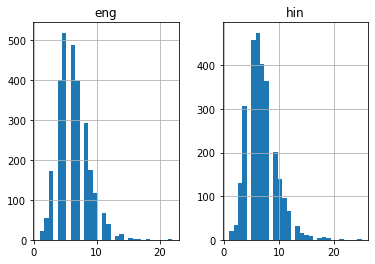

In [16]:
engl = []
hindi = []

# populate the lists with sentence lengths
for i in df[:,0]:
      engl.append(len(i.split()))

for i in df[:,1]:
      hindi.append(len(i.split()))

length_df = pd.DataFrame({'eng':engl, 'hin':hindi})

length_df.hist(bins = 30)
plt.show()

In [17]:
length_df 

,eng,hin
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
2769,17,16
2770,14,13
2771,15,18
2772,18,17


In [18]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [19]:
eng_tokenizer = tokenization(df[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 22
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 2370


In [34]:
hindi_tokenizer = tokenization(df[:, 1])
hindi_vocab_size = len(hindi_tokenizer.word_index) + 1

hindi_length = 22
print('Hindi Vocabulary Size: %d' % hindi_vocab_size)

Hindi Vocabulary Size: 2980


In [35]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [36]:
from sklearn.model_selection import train_test_split

train,val = train_test_split(df, test_size=0.2, random_state = 15)

In [37]:
train

array([['theres no use trying to persuade him',
        'उसको मनाने की कोशिश करने में कोई फ़ायदा नहीं है।'],
       ['i advise you not to borrow money from your friends',
        'मेरी तुम्हारे लिए यह सलाह है कि अपने दोस्तों से पैसे उधार मत लो।'],
       ['they live in a little village in england',
        'वे इंग्लैंड के एक छोटे से गाँव में रहते हैं।'],
       ...,
       ['he is always complaining about his boss',
        'वह हमेशा अपने बॉस की शिकायत करता रहता है।'],
       ['because of his advice i was able to succeed',
        'मैं उसकी सलाह की वजह से कामयाब हो गया।'],
       ['when will you be back it all depends on the weather',
        'कब वापस आओगे यह तो मौसम देख कर पता चलेगा।']], dtype='<U121')

In [38]:
train_X = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
train_y = encode_sequences(hindi_tokenizer, hindi_length, train[:, 1])

val_X = encode_sequences(eng_tokenizer, eng_length, val[:, 0])
val_y = encode_sequences(hindi_tokenizer, hindi_length, val[:, 1])

In [39]:
val_X.shape

(555, 22)

In [40]:
train_X.shape

(2219, 22)

In [41]:
val_y.shape

(555, 22)

In [42]:
train_y.shape

(2219, 22)

In [43]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [44]:
model = define_model(eng_vocab_size, hindi_vocab_size, eng_length, hindi_length, 512)

In [45]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [46]:
filename = 'model.final'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history=model.fit(train_X, train_y.reshape(train_y.shape[0],train_y.shape[1],1),
                    epochs=50, batch_size=512, validation_split=0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 6.3777
Epoch 00001: val_loss improved from inf to 2.66181, saving model to model.final
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.final\assets
4/4 [==============================] - 79s 20s/step - loss: 6.3777 - val_loss: 2.6618
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 2.5632
Epoch 00002: val_loss improved from 2.66181 to 2.50967, saving model to model.final
INFO:tensorflow:Assets written to: model.final\assets
4/4 [==============================] - 80s 20s/step - loss: 2.5632 - val_loss: 2.5097
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 2.4802
Epoch 00003: val_loss improved from 2.50967 to 2.39035, saving model to model.final
INFO:tensorflow:Ass

Epoch 34/50
4/4 [==============================] - ETA: 0s - loss: 1.8826
Epoch 00034: val_loss did not improve from 2.21673
4/4 [==============================] - 18s 5s/step - loss: 1.8826 - val_loss: 2.2777
Epoch 35/50
4/4 [==============================] - ETA: 0s - loss: 1.8425
Epoch 00035: val_loss did not improve from 2.21673
4/4 [==============================] - 19s 5s/step - loss: 1.8425 - val_loss: 2.2979
Epoch 36/50
4/4 [==============================] - ETA: 0s - loss: 1.8677
Epoch 00036: val_loss did not improve from 2.21673
4/4 [==============================] - 20s 5s/step - loss: 1.8677 - val_loss: 2.2777
Epoch 37/50
4/4 [==============================] - ETA: 0s - loss: 1.8432
Epoch 00037: val_loss did not improve from 2.21673
4/4 [==============================] - 21s 5s/step - loss: 1.8432 - val_loss: 2.2639
Epoch 38/50
4/4 [==============================] - ETA: 0s - loss: 1.8362
Epoch 00038: val_loss did not improve from 2.21673
4/4 [==============================

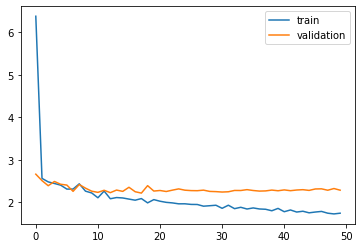

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [49]:
model = load_model('model.final')
preds = model.predict_classes(val_X.reshape((val_X.shape[0],val_X.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [58]:
np.sum((preds==val_y)*1)/len(preds)

15.504504504504505

In [59]:
preds.shape

(555, 22)